<a href="https://colab.research.google.com/github/abrahamsteep90/LondonSunHoursPrediction-RNN-CNN-DNN/blob/main/SunHoursLondonPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I will be using the [Sunshine data taken from an automatic Kipp & Zonen sensor](https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/heathrowdata.txt) dataset which contains data of the monthly sun hours recorded in Heathrow - London Airport from 1948 to 2022.


In [1]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.4.1.50-1+cuda11.6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [2]:
import gdown
import csv
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [3]:
#heathrowdata.txt
url = "https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/heathrowdata.txt"
output = "heathrowdata.txt"
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

Downloading...
From: https://www.metoffice.gov.uk/pub/data/weather/uk/climate/stationdata/heathrowdata.txt
To: /content/heathrowdata.txt
47.3kB [00:00, 30.2MB/s]                   


'heathrowdata.txt'

Begin by looking at the structure of the txt that contains the data:


In [4]:
SUNHOURS_TXT = './heathrowdata.txt'

with open(SUNHOURS_TXT) as f:
    data = f.read()[443:-582]

# Convert to lower case and save as a list
corpus = data.split()

In [5]:
my_array = np.array(corpus).reshape(888,7)
my_array

array([['1948', '1', '8.9', ..., '---', '85.0', '---'],
       ['1948', '2', '7.9', ..., '---', '26.0', '---'],
       ['1948', '3', '14.2', ..., '---', '14.0', '---'],
       ...,
       ['2021', '10', '16.9', ..., '0', '87.6', '84.2#'],
       ['2021', '11', '11.4', ..., '3', '10.2', '67.8#'],
       ['2021', '12', '10.1', ..., '3', '71.2', '21.1#']], dtype='<U6')

In [13]:
#Just to see the data
df = pd.DataFrame(my_array, columns = ['Year','mm','tmax','tmin','AirFrost','Rain','SunHours'])
df.head()

,Year,mm,tmax,tmin,AirFrost,Rain,SunHours
0,1948,1,8.9,3.3,---,85.0,---
1,1948,2,7.9,2.2,---,26.0,---
2,1948,3,14.2,3.8,---,14.0,---
3,1948,4,15.4,5.1,---,35.0,---
4,1948,5,18.1,6.9,---,57.0,---


Helper function to plot the time series.

In [31]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [32]:
def plot_xy(x, y, format="-", start=0, end=None, title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
      for y_curr in y:
        plt.plot(x[start:end], y_curr[start:end], format)
    else:
      plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
      plt.legend(legend)
    plt.title(title)
    plt.grid(True)
    plt.show()

## Parsing the raw data


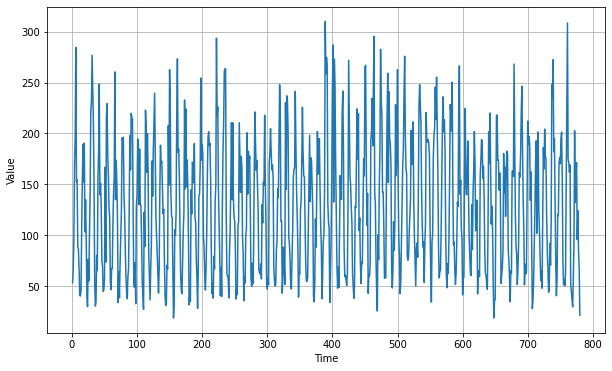

In [33]:
#Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    #Skipping nulls
    times = my_array[108:,0]
    times = [idx for idx in enumerate(times)]
    times = [i[0]+1 for i in times]
    sunhours = my_array[108:,6]
    list_sun_hours = []
    for val in sunhours:
      list_sun_hours.append(val.strip("#"))
    list_sun_hours = np.array(list_sun_hours)
    list_sun_hours=list_sun_hours.astype(np.float64)
    TIME = np.array(times)
    SERIES = np.array(list_sun_hours)
    SPLIT_TIME = 600
    WINDOW_SIZE = 12
    BATCH_SIZE = 32
    SHUFFLE_BUFFER_SIZE = 100


plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.show()

## Processing the data


In [17]:
def train_val_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid

# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(G.TIME, G.SERIES)

In [18]:
def windowed_dataset(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds
    
# Apply the transformation to the training set
train_set = windowed_dataset(series_train, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE, shuffle_buffer=G.SHUFFLE_BUFFER_SIZE)

## Defining the model architecture


In [19]:
def create_uncompiled_model():

    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(filters = 64, kernel_size = 3,
                             strides =1,
                             activation = "relu",
                             padding = 'causal',
                             input_shape =  [G.WINDOW_SIZE, 1]),
        tf.keras.layers.LSTM(64, return_sequences = True),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(30, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'relu'),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Lambda(lambda x: x*400)
        
    ]) 

    return model

## Adjusting the learning rate

In [20]:
def adjust_learning_rate(dataset):
    
    model = create_uncompiled_model()
    
    lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-9 * 10**(epoch / 20))
    
    optimizer = tf.keras.optimizers.SGD(momentum = 0.9)
    
    # Compile the model passing in the appropriate loss
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=optimizer, 
                  metrics=["mae"]) 

    history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])
    
    return history

In [21]:
# Run the training with dynamic LR
lr_history = adjust_learning_rate(train_set)

Epoch 1/100
19/19 [==============================] - 5s 38ms/step - loss: 128.6744 - mae: 129.1744 - lr: 1.0000e-09
Epoch 2/100
19/19 [==============================] - 0s 20ms/step - loss: 128.4969 - mae: 128.9969 - lr: 1.1220e-09
Epoch 3/100
19/19 [==============================] - 0s 20ms/step - loss: 128.2626 - mae: 128.7626 - lr: 1.2589e-09
Epoch 4/100
19/19 [==============================] - 0s 20ms/step - loss: 127.9954 - mae: 128.4954 - lr: 1.4125e-09
Epoch 5/100
19/19 [==============================] - 0s 21ms/step - loss: 127.6952 - mae: 128.1953 - lr: 1.5849e-09
Epoch 6/100
19/19 [==============================] - 0s 20ms/step - loss: 127.3585 - mae: 127.8585 - lr: 1.7783e-09
Epoch 7/100
19/19 [==============================] - 0s 21ms/step - loss: 126.9807 - mae: 127.4807 - lr: 1.9953e-09
Epoch 8/100
19/19 [==============================] - 0s 20ms/step - loss: 126.5571 - mae: 127.0571 - lr: 2.2387e-09
Epoch 9/100
19/19 [==============================] - 0s 22ms/step - loss

(1e-09, 0.001, 0.0, 130.0)

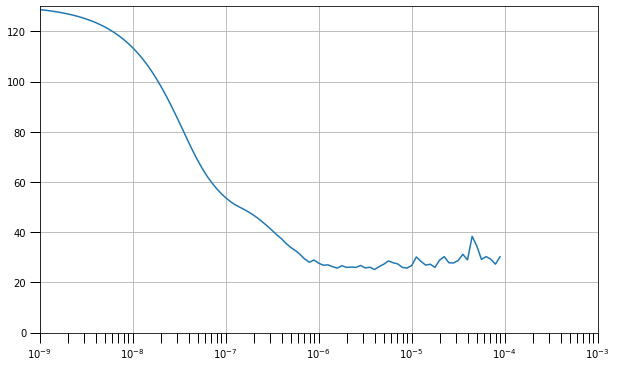

In [24]:
# Define the learning rate array
lrs = 1e-9 * (10 ** (np.arange(100) / 20))

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, lr_history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-9, 1e-3, 0, 130])

## Compiling the model

In [40]:
def create_model():

    model = create_uncompiled_model()
    tf.keras.backend.clear_session()
    learning_rate = 1e-06
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9),
                  metrics=["mae"])  

    return model

In [41]:
# Save an instance of the model
model = create_model()

# Train it
history = model.fit(train_set, epochs=50)

Epoch 1/50
19/19 [==============================] - 5s 32ms/step - loss: 130.8995 - mae: 131.3995
Epoch 2/50
19/19 [==============================] - 0s 21ms/step - loss: 92.5404 - mae: 93.0388
Epoch 3/50
19/19 [==============================] - 0s 20ms/step - loss: 70.3974 - mae: 70.8963
Epoch 4/50
19/19 [==============================] - 0s 21ms/step - loss: 61.3839 - mae: 61.8820
Epoch 5/50
19/19 [==============================] - 0s 20ms/step - loss: 57.7900 - mae: 58.2883
Epoch 6/50
19/19 [==============================] - 0s 21ms/step - loss: 56.2624 - mae: 56.7615
Epoch 7/50
19/19 [==============================] - 0s 20ms/step - loss: 55.5352 - mae: 56.0334
Epoch 8/50
19/19 [==============================] - 0s 21ms/step - loss: 55.2040 - mae: 55.7024
Epoch 9/50
19/19 [==============================] - 0s 20ms/step - loss: 54.9004 - mae: 55.3995
Epoch 10/50
19/19 [==============================] - 0s 20ms/step - loss: 54.4945 - mae: 54.9924
Epoch 11/50
19/19 [==================

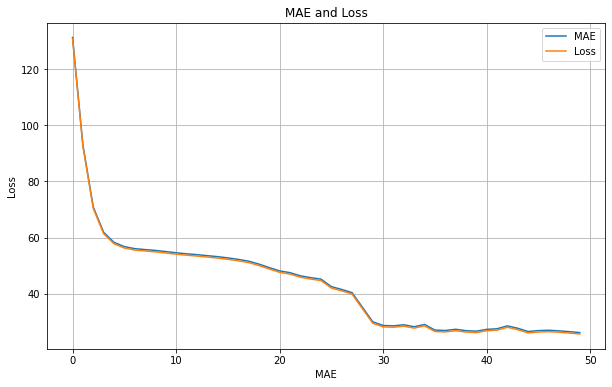

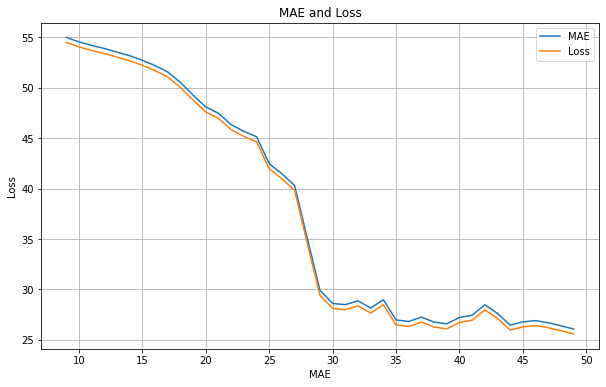

In [42]:
# Get mae and loss from history log
mae=history.history['mae']
loss=history.history['loss']

# Get number of epochs
epochs=range(len(loss)) 

# Plot mae and loss
plot_xy(
    x=epochs, 
    y=(mae, loss), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

# Only plot the last 80% of the epochs
zoom_split = int(epochs[-1] * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

# Plot zoomed mae and loss
plot_xy(
    x=epochs_zoom, 
    y=(mae_zoom, loss_zoom), 
    title='MAE and Loss', 
    xlabel='MAE',
    ylabel='Loss',
    legend=['MAE', 'Loss']
    )

## Evaluating the forecast


In [43]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae

##Model forecasts


In [44]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

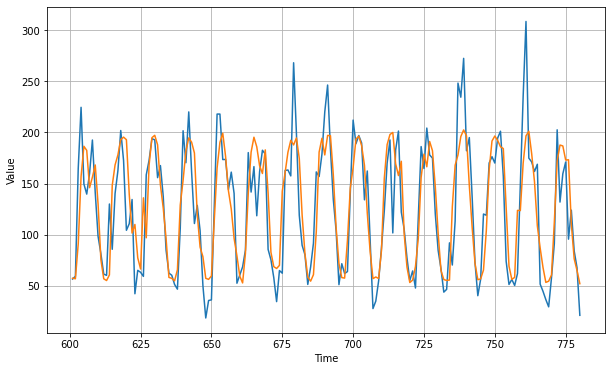

In [45]:
# Compute the forecast for all the series
rnn_forecast = model_forecast(model, G.SERIES, G.WINDOW_SIZE).squeeze()

# Slice the forecast to get only the predictions for the validation set
rnn_forecast = rnn_forecast[G.SPLIT_TIME - G.WINDOW_SIZE:-1]

# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(time_valid, rnn_forecast)

In [46]:
mse, mae = compute_metrics(series_valid, rnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 1207.87, mae: 26.25 for forecast


In [47]:
#2022 prediction for 12 months
future_list = G.SERIES.tolist()
for i in range(768,780,1):
  rnn_forecast_next = [model_forecast(model, future_list[i:], G.WINDOW_SIZE).squeeze().tolist()]
  future_list += rnn_forecast_next
future_list = np.array(future_list)[-12:]
future_list

  

array([ 56.81960678,  69.05906677, 134.59205627, 179.20265198,
       197.06582642, 200.03817749, 188.63330078, 147.08053589,
       126.85817719,  93.39813232,  63.0396347 ,  54.45241165])

In [48]:
currentStep = np.arange(601,793,1)
forecast_val_list = rnn_forecast.tolist()
cat_val_fut = forecast_val_list+future_list.tolist()

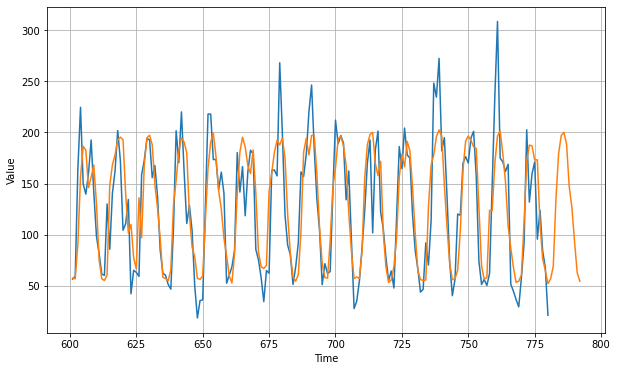

In [49]:
# Plot the forecast +  future
plt.figure(figsize=(10, 6))
plot_series(time_valid, series_valid)
plot_series(currentStep,cat_val_fut)